In [2]:
import matplotlib.pyplot as plt
from numpy.random import default_rng
import numpy as np
import torch

from utils import split_data_gnn, train, MLP, get_batch_dimensions, visualize_graph
import torch.nn.functional as F
from torch import nn
from torch.utils.data import  DataLoader
from IPython.display import clear_output
import numpy as np
import mdtraj as md
from schnet import RadiusInteractionGraph, SchNet

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

### Generate some fake data

In [5]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)


In [7]:
n_particles = clus3d.shape[0]

In [31]:
n_samples = 10

positions = clus3d + torch.rand(size=(n_samples, n_particles,3))
potential_energies = torch.rand(size=(n_samples,1))
n_samples = potential_energies.shape[0]
positions.shape, potential_energies.shape

(torch.Size([10, 7, 3]), torch.Size([10, 1]))

We store the data in a Dataset. For now, we only need one dataset to make some tests. We assign atomic number of 1 to all particles

In [34]:
z = torch.ones((n_samples,1))

We first make a histogram of all pairwise distances to get a feeling how our data is distributed. To do that, we use torch.vmap: It applies the mapped function over the first dimension.

In [35]:
# pairwise distances for all samples
distances = torch.vmap(F.pdist)(positions)
distances.shape

/home/psireal42/miniconda3/envs/mltutorial/lib/python3.10/site-packages/torch/_functorch/vmap.py:379: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::pdist. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /croot/pytorch-select_1700158693612/work/aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  batched_outputs = func(*batched_inputs, **kwargs)


torch.Size([10, 21])

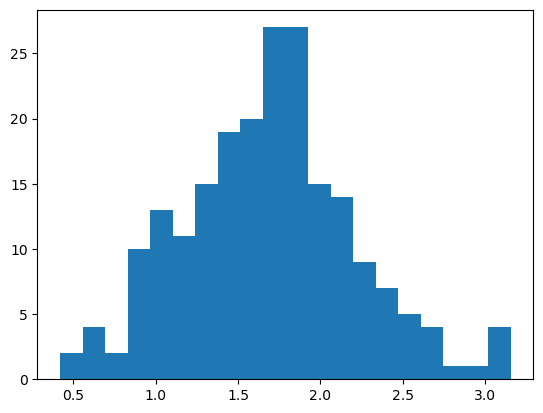

In [15]:
plt.hist(distances.flatten(),bins=20);

### Visualizing the interaction graph
We can now plot the interaction graph, which is the central object of a GNN. To do so, we use functions from pytorch_geometric. 

<span style="color:red">Caution:</span>

pytorch_geometric expects the input positions to be of shape (n_samples * n_particles, 3), rather than (n_samples, n_particles, 3). In practice, we can easily achieve that using reshape(-1,3), but it is important to keep that in mind.

The batch_dimensions tell the code, which atom belongs to which sample of the array with shape (n_samples * n_particles, 3). For example: If we work with the first 14 entries, i.e., 2 samples from the MD run, the first seven positions correspond to one samples, and the second one to a different sample.

In [131]:
batch_dimensions = get_batch_dimensions(batch_size=1, n_particles=7)
batch_dimensions.shape

torch.Size([7])

## 1.1.1 Graph

In [129]:
# select one frame from the MD simulation
id_plot = 5

# define a cutoff for the interaction
r_cut = 1.5

### Radius interaction graph

- Forward pass: process of passing input data through the network to generate an output. During the forward pass, input data is passed through the layers of the network to produce predictions or other relevant outputs. This method is called automatically when data are passed through an instance of the class.
- Idea: 
    * Edge construction based on pairwise distances between nodes belonging in the same batch. Nodes in different batch should not be connected.
    * It's a weighted graph with the weight being the distance between 2 nodes.


In [198]:
interaction_graph = RadiusInteractionGraph(r_cut)
batch_dimensions = get_batch_dimensions(batch_size=1, n_particles=7)
edges, distances = interaction_graph(
    positions[id_plot].reshape(-1, 3), batch_dimensions
)

edges.shape, distances.shape

torch.Size([7, 3])


(torch.Size([2, 18]), torch.Size([18]))

In [61]:
batch_size=2
z = torch.ones(size=(n_particles * batch_size, 1))

torch.Size([14, 1])


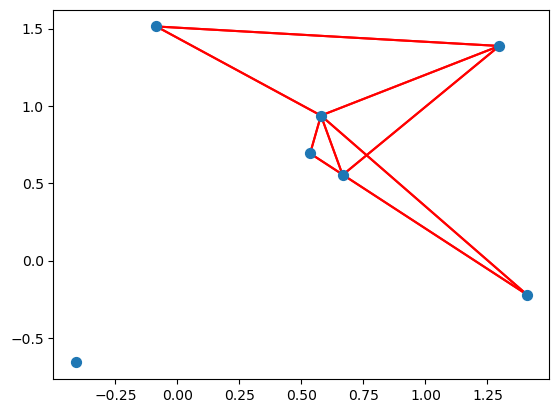

In [15]:
visualize_graph(positions[id_plot].reshape(-1,3),edges,dim_1=0, dim_2=1)

#### Different cutoff


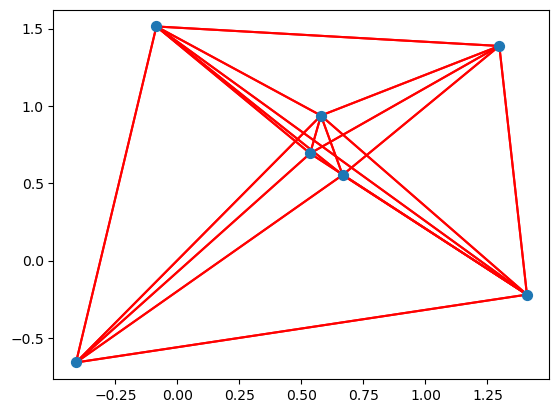

In [13]:
interaction_graph = RadiusInteractionGraph(cutoff=2.5)
batch_dimensions = get_batch_dimensions(batch_size=1, n_particles=7)

edges, distances = interaction_graph(
    positions[id_plot].reshape(-1, 3), batch_dimensions
)

visualize_graph(positions[id_plot].reshape(-1,3),edges,dim_1=0, dim_2=1)

## 1.1.2 Embedding

The atom $i$ at layer $l$ is described by a feature vector $\mathbf{x}^l_i \in \mathbb{R}^F$, where $F$ is the feature dimension. For first layer, we have $\mathbf{x}^0_i=\mathbf{a}(Z)$, where $\mathbf{a}$ could be an ouput of a MLP or a single linear layer. In publication, the atom type embeddings $\mathbf{a}(Z)$ are initialized randomly and optimized during training.

In [16]:
Z = 1.0
num_features = 32 # 32 atomwise features. Why 32? Idk ...
x_0 = np.random.rand(num_features)

## 1.1.3 Radial basis expansion

In [17]:
from dataclasses import dataclass

@dataclass
class RadialExpansion:
    gamma: float
    mu_k: torch.Tensor
    d_ji: float

    def expand(self) -> torch.Tensor:
        return torch.exp(-self.gamma * (self.d_ji - self.mu_k)**2)

In [18]:
r_cut = 1.5
radial_expansion_0_5 = RadialExpansion(gamma=4.0,
                                   mu_k=torch.linspace(0,r_cut,10),
                                   d_ji=0.5)
gaussian_basis_0_5 = radial_expansion_0_5.expand()

radial_expansion_1_0 = RadialExpansion(gamma=4.0,
                                   mu_k=torch.linspace(0,r_cut,10),
                                   d_ji=1.0)
gaussian_basis_1_0 = radial_expansion_1_0.expand()

radial_expansion_1_5 = RadialExpansion(gamma=4.0,
                                   mu_k=torch.linspace(0,r_cut,10),
                                   d_ji=1.5)
gaussian_basis_1_5 = radial_expansion_1_5.expand()

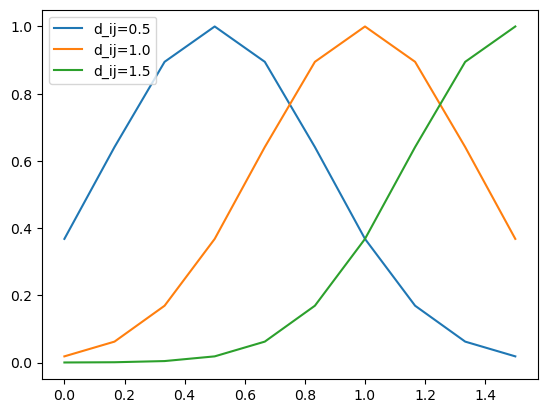

In [20]:
import matplotlib.pyplot as plt

mu_k = np.linspace(0, r_cut,10)
plt.figure()
plt.plot(mu_k, gaussian_basis_0_5, label="d_ij=0.5")
plt.plot(mu_k, gaussian_basis_1_0, label="d_ij=1.0")
plt.plot(mu_k, gaussian_basis_1_5, label="d_ij=1.5")
plt.legend()
plt.show()

Q: What is the idea behind using this type of expansion?

A: 
- Every pairwise interaction distance $d_{ij}$ is expanded in a basis of Gaussians $e_k(d_{ji}) = \exp(- \gamma (d_{ij} - \mu_k)^2) \rightarrow$  create continuous functions centered at $d_{ij}$ that capture the interaction (strength) between atoms in a system. The gaussian basis are then used to update the node representations in the graph. $\mu$ and $\sigma$ are learned parameters for representing the characteristics of the data.
- When the filter-generating networks produce RBF filters for different pairwise distances, and these filters are applied independently to different distances, then the resulting filters can be considered independent. The uncorrelated nature of filters is desirable because it allows the network to learn diverse and non-redundant features from different distances.

### SchNet

In [18]:
# initialize a SchNet model with default values
model = SchNet()

In [19]:
# Let's get some information about the model parameters
print(model)

SchNet(dim_embedding=32, num_filters=32, num_interactions=2, num_gaussians=10, cutoff=5.0)


 You can check your implementation by passing the data to the model. This should look like the following:

In [20]:
batch_dimensions = get_batch_dimensions(batch_size=10, n_particles=n_particles)

In [ ]:
# A forward pass of the model looks like this:
# out = model.forward(z,pos.reshape(-1,3),batch_dimensions)

## 1.2 Do you want to build a SchNet? #Frozen

Now we can bring all the relevant layers together and build SchNet. First, we need to initialize
the relevant layers. Besides the already implemented layers, we need:
1. An embedding layer (torch.linear) which takes as input the atomic number and outputs
the embedding vector.
2. A layer to obtain the interaction graph (use RadiusInteractionGraph).
3. A layer for the expansions in radial basis functions.


The forward pass should consist of:
1. Generating the embedding vectors of all atoms (see 1.1.2). Since this is operation is
identitical for each atom, you can use torch.vmap to map over the first dimension. The
output should be of shape (n_atoms * batch_size, dim_embedding).
2. Computing the interaction graph (i.e., get indices and distances between atoms within
the cutoff).
3. Expanding the distances into radial basis functions. You can again use torch.vmap to
map over the batch dimensions.
The resulting array should have dimension (n_pairs * batch_size, num_gaussians).
4. Residual update of the embedding vector using the interaction blocks (already implemented).
5. Readout (already implemented).

In [14]:
import os
import os.path as osp
import warnings
from math import pi as PI
from typing import Callable, Dict, Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Embedding, Linear, ModuleList, Sequential

from torch_geometric.nn import MessagePassing, SumAggregation, radius_graph
from torch_geometric.nn.resolver import aggregation_resolver as aggr_resolver
from torch_geometric.typing import OptTensor
from utils import MLP, get_batch_dimensions
from schnet_utils import RadiusInteractionGraph, InteractionBlock, ShiftedSoftplus

from dataclasses import dataclass

@dataclass
class RadialExpansion:
    gamma: float
    mu_k: torch.Tensor

    def expand(self, d_ji) -> torch.Tensor:
        return torch.exp(-self.gamma * (d_ji - self.mu_k)**2)

class SchNet(torch.nn.Module):
    """
    Args:
        dim_embedding (int, optional): Embedding size.
            (default: :obj:`128`)
        num_filters (int, optional): The number of filters to use.
            (default: :obj:`128`)
        num_interactions (int, optional): The number of interaction blocks.
            (default: :obj:`6`)
        num_gaussians (int, optional): The number of gaussians :math:`\mu`.
            (default: :obj:`50`)
        cutoff (float, optional): Cutoff distance for interatomic interactions.
            (default: :obj:`10.0`)
    """

    def __init__(
        self,
        dim_embedding: int = 32,
        num_filters: int = 32,
        num_interactions: int = 2,
        num_gaussians: int = 10,
        cutoff: float = 5.0,
    ):
        super().__init__()

        self.dim_embedding = dim_embedding
        self.num_filters = num_filters
        self.num_interactions = num_interactions
        self.num_gaussians = num_gaussians
        self.cutoff = cutoff
        self.readout = aggr_resolver("add")

        # Embedding Layer
        self.embedding = Linear(in_features=1,
                                   out_features=dim_embedding)

        # Interaction graph layer
        self.interaction_graph = RadiusInteractionGraph(r_cut)

        # Radial basis expansion layer
        self.distance_expansion = RadialExpansion(gamma = 4.0,
                                                  mu_k = torch.linspace(0, cutoff, num_gaussians))

        # Interaction
        self.interactions = ModuleList()
        for _ in range(num_interactions):
            block = InteractionBlock(
                dim_embedding, num_gaussians, num_filters, cutoff
            )
            self.interactions.append(block)

        # Readout
        self.lin1 = Linear(dim_embedding, dim_embedding // 2)
        self.act = ShiftedSoftplus()
        self.lin2 = Linear(dim_embedding // 2, 1)

    def forward(self, z: torch.tensor, pos: torch.tensor, batch_dimensions):
        r"""Forward pass.

        Args:
            z (torch.Tensor): Atomic number of each atom with shape
                :obj:`[num_samples * num_atoms, 1]`.
            pos (torch.Tensor): Coordinates of each atom with shape
                :obj:`[num_samples * num_atoms, 3]`.
            batch (torch.Tensor): Batch indices assigning each atom
                to a separate molecule with shape :obj:`[num_samples * num_atoms]`.
        """

        # Embedding of atomic charge
        h = torch.vmap(self.embedding)(z)

        # Interaction graph from atomic positions
        edges, distances = self.interaction_graph(pos, batch_dimensions)

        # expand distances in radial basis functions
        radial_expansion = torch.vmap(self.distance_expansion.expand)(distances)

        for interaction in self.interactions:
            h = h + interaction(h, edges, distances, radial_expansion)

        # Readout
        h = self.lin1(h)
        h = self.act(h)
        h = self.lin2(h)

        out = self.readout(h, batch_dimensions, dim=0)

        return out

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}("
            f"dim_embedding={self.dim_embedding}, "
            f"num_filters={self.num_filters}, "
            f"num_interactions={self.num_interactions}, "
            f"num_gaussians={self.num_gaussians}, "
            f"cutoff={self.cutoff})"
        )


#### Testing

In [11]:
r_cut = 1.5
n_particles = 7
model = SchNet()
batch_size = 10
print(model)
batch_dimensions = get_batch_dimensions(batch_size=batch_size, n_particles=n_particles)

SchNet(dim_embedding=32, num_filters=32, num_interactions=2, num_gaussians=10, cutoff=5.0)


In [17]:
d = 1.1

# 3d cluster
clus3d = torch.tensor(
    [
        [0.0, 0.0, 0.0],
        [d / np.sqrt(2.), d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), d / np.sqrt(2), 0.0],
        [d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [-d / np.sqrt(2), -d / np.sqrt(2), 0.0],
        [0, 0, d],
        [0, 0, -d],
    ],dtype=torch.float32
)
pos = clus3d + torch.rand(size=(batch_size, n_particles,3))

z = torch.ones(size=(n_particles * batch_size, 1))

out = model.forward(z,pos.reshape(-1,3),batch_dimensions)
print(f"{out=}") # Output

out=tensor([[-0.2817],
        [-0.2700],
        [-0.2974],
        [-0.3079],
        [-0.3011],
        [-0.3057],
        [-0.3056],
        [-0.3010],
        [-0.3000],
        [-0.3013]], grad_fn=<ScatterAddBackward0>)
